<a href="https://colab.research.google.com/github/YashBachkar20/smoker-classification/blob/main/smoker_classification_using_cnn_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<h1 style="font-family:verdana;"> <center>Smoker Classification using Deep Convolutional Neural Networks and Transfer Learning</center> </h1>**
<p><center style="color:#159364; font-family:cursive;"> </center></p>

***




# Overview
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">Tobacco is extremely harmful and there is no safe level of exposure to it. While cigarette smoking is the most widespread form of tobacco use, other tobacco products like waterpipe tobacco, various smokeless tobacco products, cigars, cigarillos, roll-your-own tobacco, pipe tobacco, bidis and kreteks are also harmful. Research has proved that more than half of tobacco users are eventually killed by it. Currently, 7 million tobacco users die every year. The negative effects of using tobacco range from physical impacts like shortness of breath, throat and tongue cancer to mental impacts like increased anxiety and stress.</p>


<h3><b>The health benefits of quitting tobacco</b></h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">Quitting tobacco is not easy, but the health benefits far outweigh the health risks. When you stop smoking, the benefits start almost immediately. Your heart rate and blood pressure drop in only 20 minutes. Within 12 hours, the carbon monoxide level in your blood returns to normal and coughing and shortness of breath can decrease in as little as one month. Ultimately, when you quit tobacco, you will experience improved breathing with healthy lungs and increase your chances of a longer life. </p>






# **Import Necessary Libraries**





In [ ]:
!pip install Keras-Preprocessing
#conda install -c conda-forge keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random


# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix


# **Create helper functions**

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-10-25 17:04:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-25 17:04:34 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# **Load and Transform Data**

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [ ]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vitaminc/cigarette-smoker-detection

import zipfile
zip_ref = zipfile.ZipFile('cigarette-smoker-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Saving kaggle.json to kaggle.json
cigarette-smoker-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Walk through each directory
dataset = "./data"
walk_through_dir(dataset)

There are 3 directories and 1 images in './data'.
There are 0 directories and 1996 images in './data/smoking'.
There are 2 directories and 1 images in './data/data'.
There are 0 directories and 1996 images in './data/data/smoking'.
There are 0 directories and 1279 images in './data/data/not_smoking'.
There are 0 directories and 1279 images in './data/not_smoking'.


# **Placing data into a Dataframe**


In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))  + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.gif'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath        Label
0              data/smoking/ggg599.JPG      smoking
1              data/smoking/ggg071.JPG      smoking
2              data/smoking/b00129.JPG      smoking
3              data/smoking/ggg092.JPG      smoking
4              data/smoking/000129.JPG      smoking
...                                ...          ...
6531  data/data/not_smoking/ggg079.gif  not_smoking
6532  data/data/not_smoking/ggg225.gif  not_smoking
6533       data/not_smoking/gg0535.gif  not_smoking
6534       data/not_smoking/ggg079.gif  not_smoking
6535       data/not_smoking/ggg225.gif  not_smoking

[6536 rows x 2 columns]

### Visualizing images from the dataset

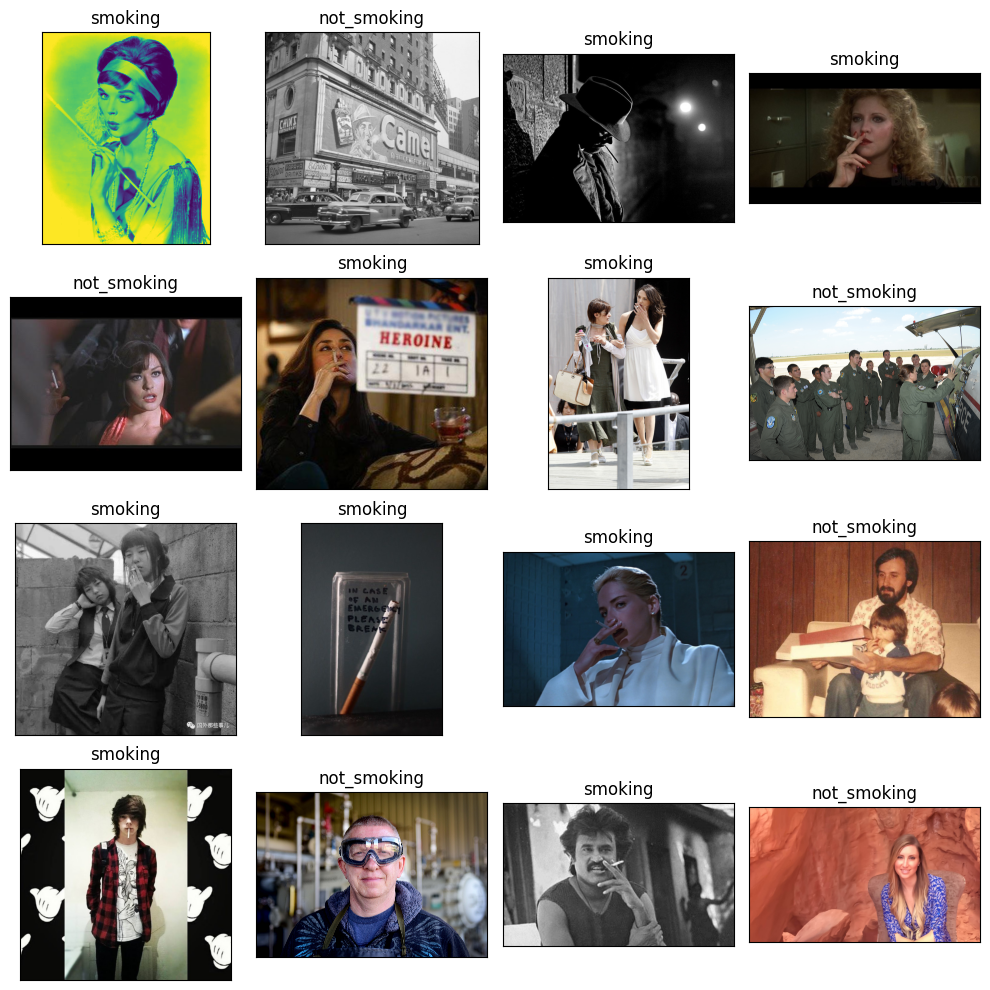

In [ ]:
# Display 16 pictures from the dataset with their labels
import numpy as np
import matplotlib.pyplot as plt

# Assuming that your DataFrame is correctly loaded and contains data
random_index = np.random.randint(0, len(image_df), 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df['Filepath'].iloc[random_index[i]]))
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [ ]:
print(image_df.head())

                  Filepath    Label
0  data/smoking/ggg599.JPG  smoking
1  data/smoking/ggg071.JPG  smoking
2  data/smoking/b00129.JPG  smoking
3  data/smoking/ggg092.JPG  smoking
4  data/smoking/000129.JPG  smoking


In [ ]:
 len(image_df)

6536

# **Computing Error Rate Analysis**

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

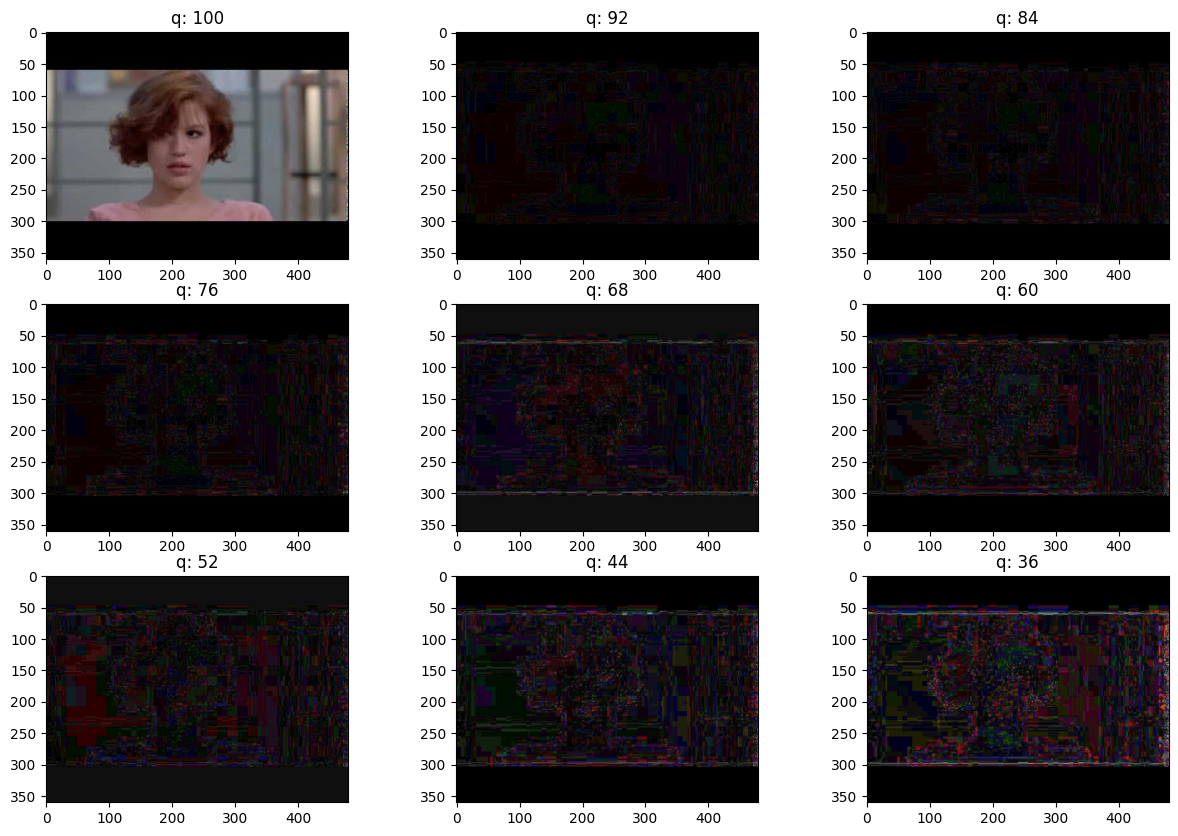

In [ ]:
# View random sample from the dataset
p = "/content/data/not_smoking/000015.jpg"
#print('p')
orig = cv2.imread(p)
#orig = cv2.cvtColor(orig,cv2.COLOR_BGR2RGB)/255.0

#img = cv2.imread(img_path)
#if(orig is not None):
#    cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
orig = cv2.cvtColor(orig,cv2.COLOR_BGR2RGB)/255.0

init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

### Data Preprocessing
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4160 validated image filenames belonging to 2 classes.
Found 1039 validated image filenames belonging to 2 classes.
Found 1297 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 29 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 29 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 11 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# Training the model
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

**Batch size** : 32

**Epochs** : 50

**Input Shape** : (224, 224, 3)

**Output layer** : 2



In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "smokers_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

# **Training the model**

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "smoker_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/smoker_classification/20231025-171759
Epoch 1/50
 27/130 [=====>........................] - ETA: 55s - loss: 3.0235 - accuracy: 0.5567

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


130/130 [==============================] - 121s 827ms/step - loss: 2.7660 - accuracy: 0.5404 - val_loss: 1.1086 - val_accuracy: 0.6121
Epoch 2/50
130/130 [==============================] - 96s 739ms/step - loss: 2.0178 - accuracy: 0.5611 - val_loss: 0.8095 - val_accuracy: 0.6583
Epoch 3/50
130/130 [==============================] - 84s 647ms/step - loss: 1.6009 - accuracy: 0.5779 - val_loss: 0.7289 - val_accuracy: 0.6968
Epoch 4/50
130/130 [==============================] - 83s 644ms/step - loss: 1.2971 - accuracy: 0.6125 - val_loss: 0.6687 - val_accuracy: 0.7093
Epoch 5/50
130/130 [==============================] - 85s 657ms/step - loss: 1.1814 - accuracy: 0.6173 - val_loss: 0.5972 - val_accuracy: 0.7324
Epoch 6/50
130/130 [==============================] - 84s 648ms/step - loss: 1.0646 - accuracy: 0.6341 - val_loss: 0.5836 - val_accuracy: 0.7401
Epoch 7/50
130/130 [==============================] - 83s 639ms/step - loss: 0.9649 - accuracy: 0.6416 - val_loss: 0.5589 - val_accuracy: 0.

# Model Evaluation
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>


In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.33668
Test Accuracy: 86.04%


# **Visualizing loss curves**

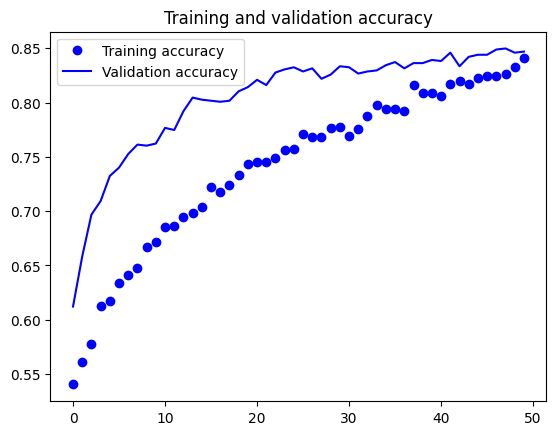

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# 🔮Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

41/41 [==============================] - 24s 558ms/step
The first 5 predictions: ['smoking', 'smoking', 'smoking', 'smoking', 'smoking']


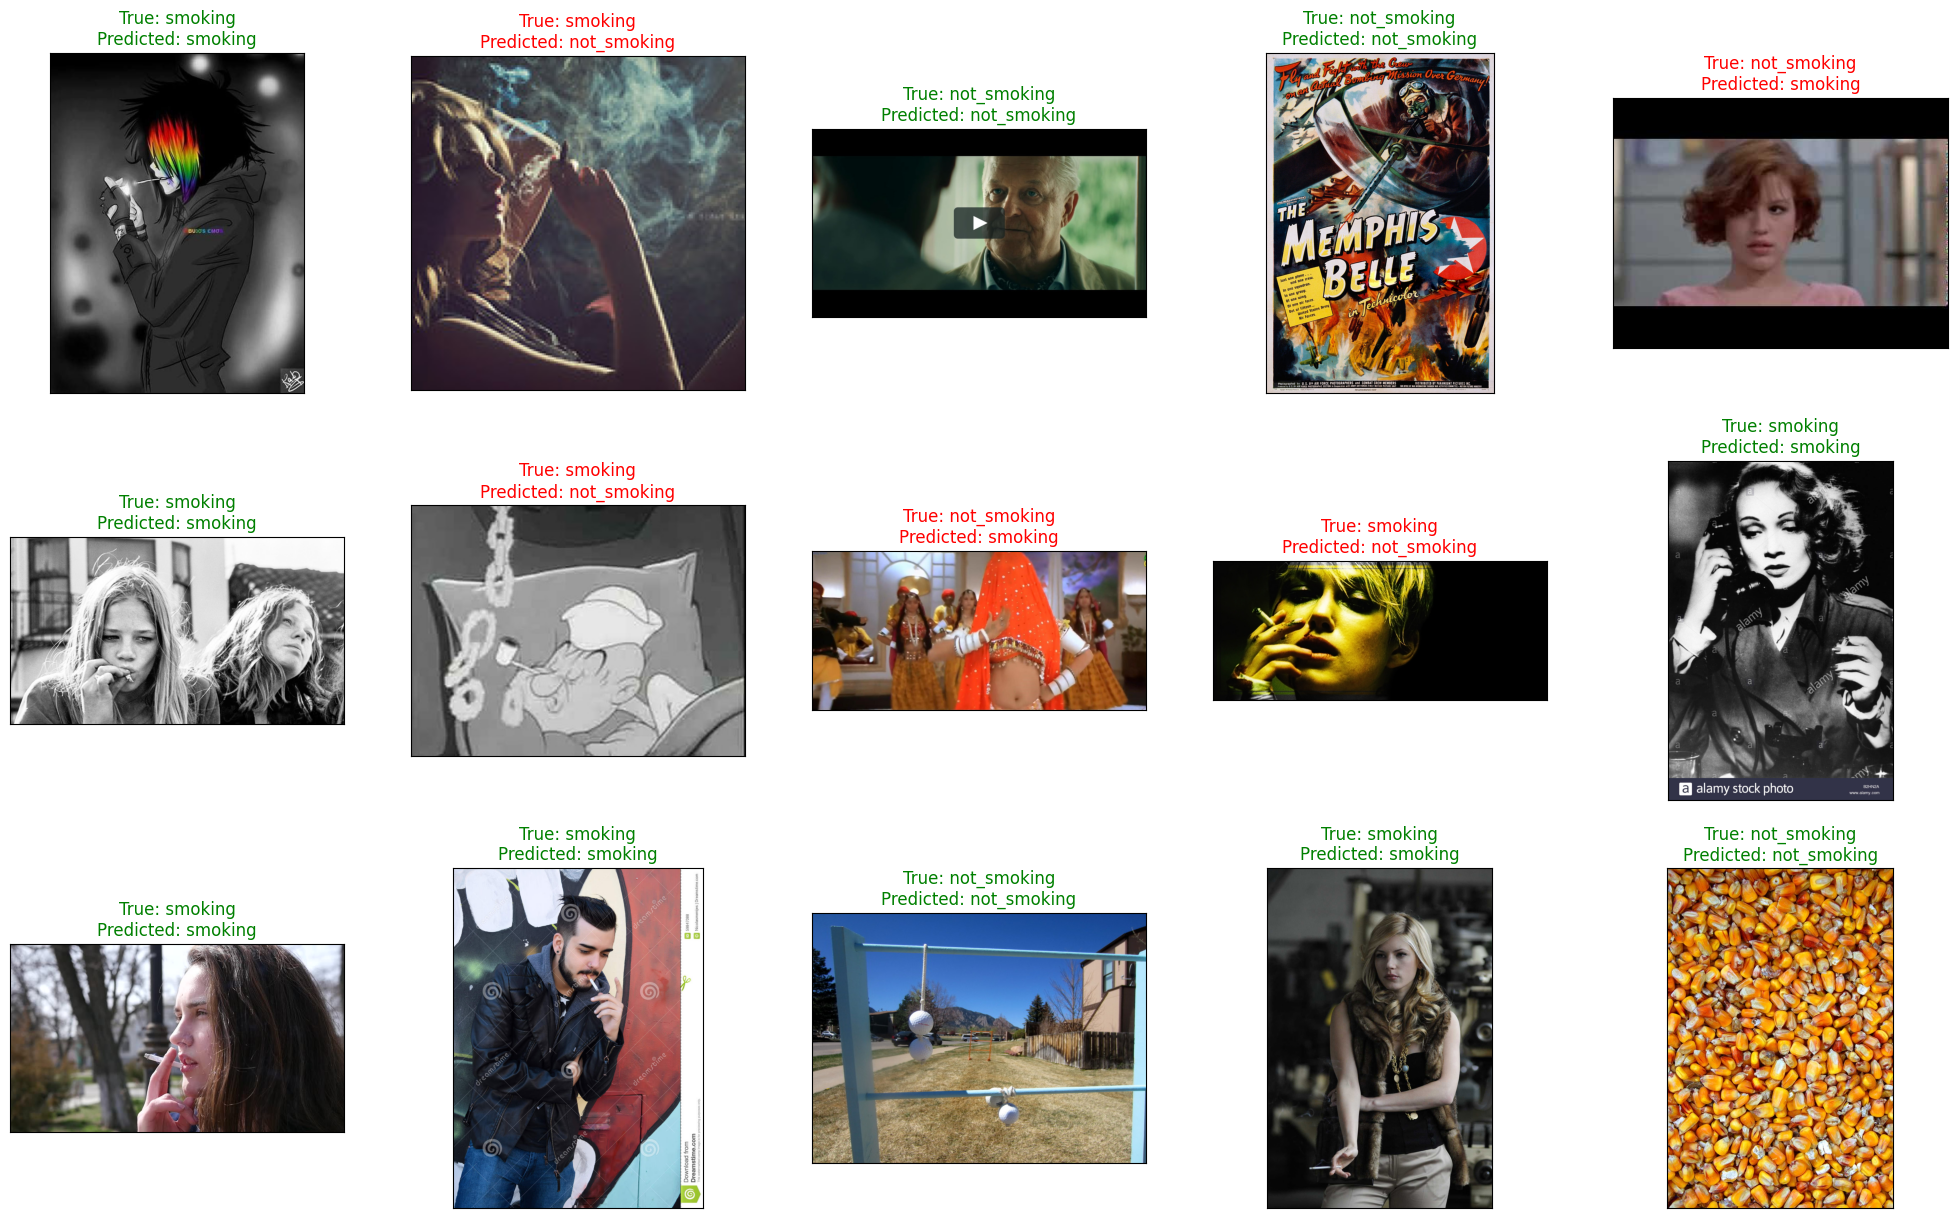

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test[:-11], pred))

              precision    recall  f1-score   support

 not_smoking       0.46      0.38      0.42       479
     smoking       0.67      0.73      0.70       818

    accuracy                           0.60      1297
   macro avg       0.56      0.56      0.56      1297
weighted avg       0.59      0.60      0.59      1297



In [ ]:
report = classification_report(y_test[:-11], pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
not_smoking    0.455446  0.384134  0.416761   479.00000
smoking        0.669653  0.731051  0.699006   818.00000
accuracy       0.602930  0.602930  0.602930     0.60293
macro avg      0.562549  0.557592  0.557884  1297.00000
weighted avg   0.590543  0.602930  0.594769  1297.00000

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


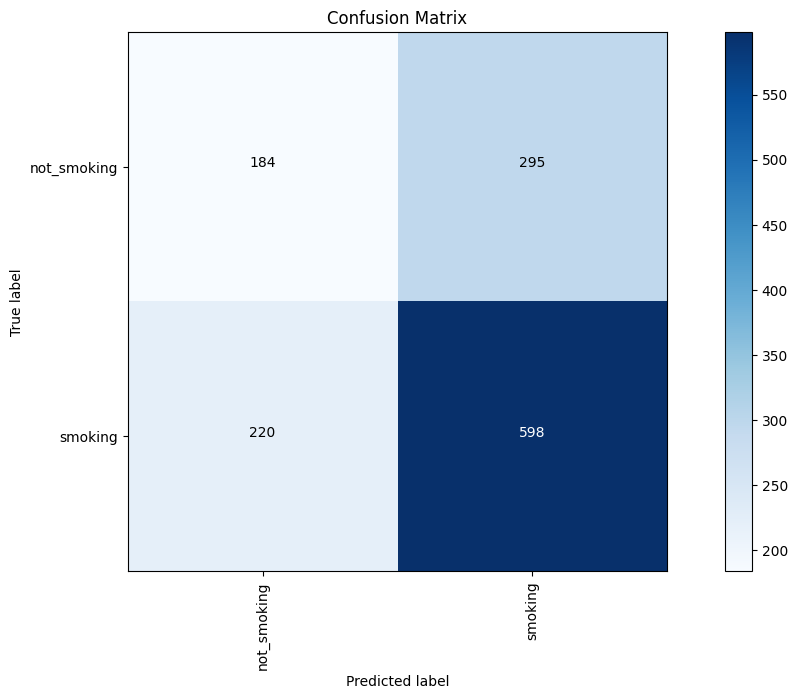

In [ ]:
make_confusion_matrix(y_test[:-11], pred, list(labels.values()))

# ☀️Grad-Cam Visualization


In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-36-11b785a06756>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


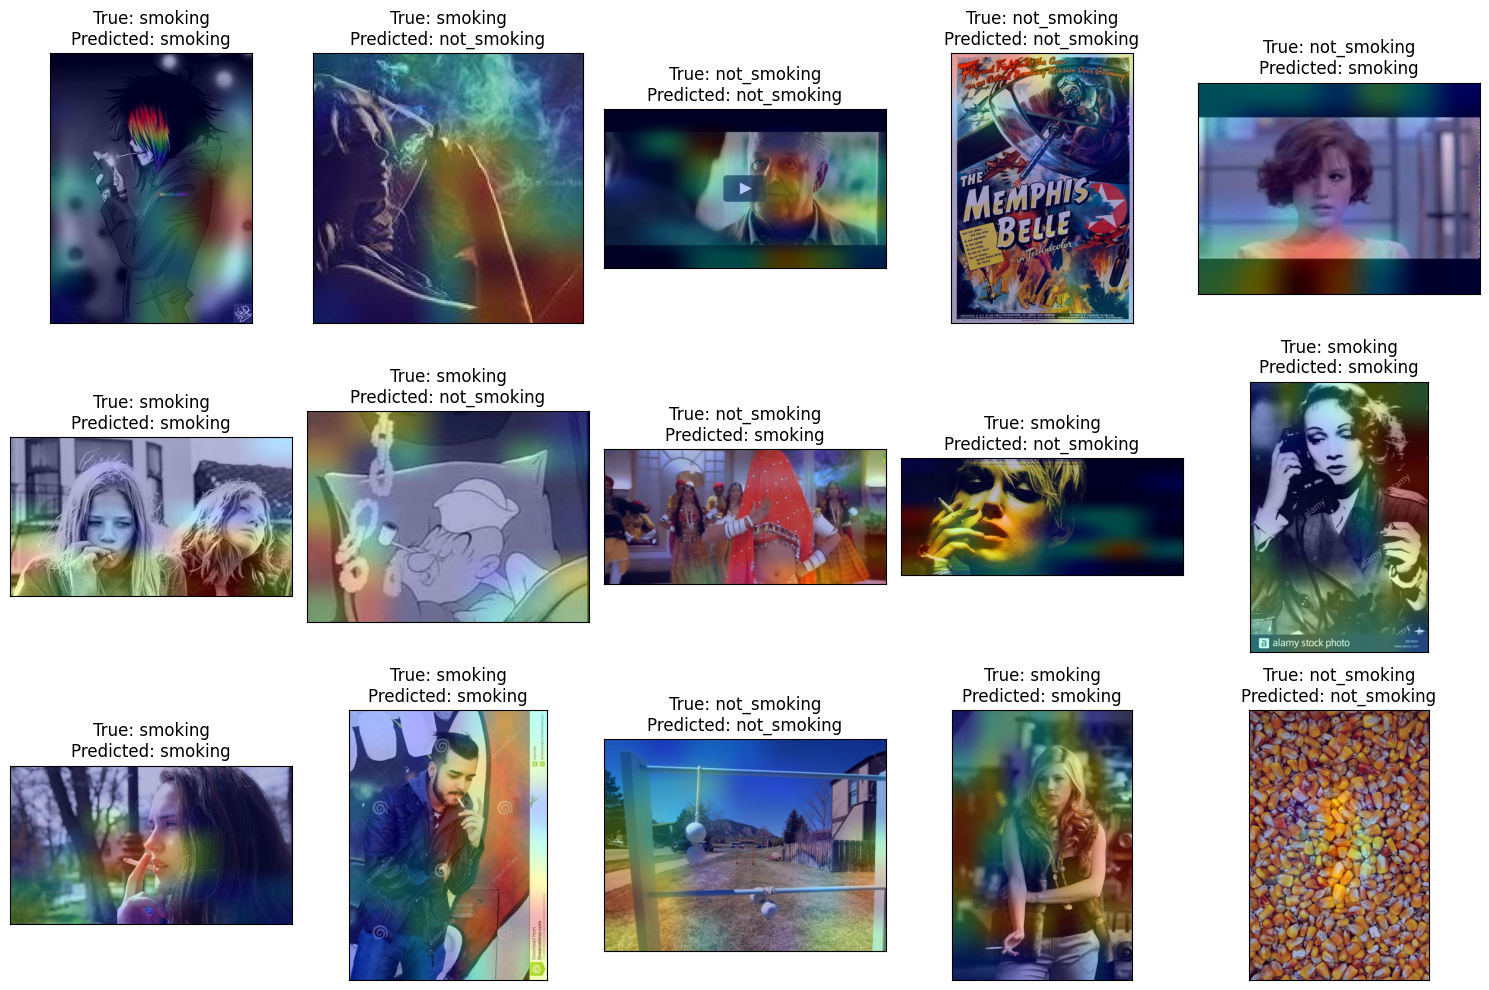

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

# **Save the model**

In [42]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [45]:
# model.save('my_model.keras')
model.save('./my_model')

In [53]:
!tar -czvf "/content/my_model.tar.gz" "/content/my_model"

tar: Removing leading `/' from member names
/content/my_model/
/content/my_model/variables/
/content/my_model/variables/variables.index
/content/my_model/variables/variables.data-00000-of-00001
/content/my_model/keras_metadata.pb
/content/my_model/assets/
/content/my_model/fingerprint.pb
/content/my_model/saved_model.pb


# **Load Trained Model**

In [54]:
new_model = tf.keras.models.load_model('my_model')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [57]:
results = new_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 7.57010
Test Accuracy: 86.04%
